In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
project_id = '<>'

## Fetch data 

We start by fetching ~30K records from the original dataset:

In [5]:
sql = """SELECT 
              unique_key
            , taxi_id
            , trip_start_timestamp
            , trip_end_timestamp
            , trip_seconds
            , trip_miles
            , pickup_census_tract
            , dropoff_census_tract
            , pickup_community_area
            , dropoff_community_area
            , pickup_latitude
            , pickup_longitude
            , dropoff_latitude
            , dropoff_longitude
            , payment_type
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE RAND() < (30000/112860054) 
AND  trip_start_timestamp < '2016-01-01' """
df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

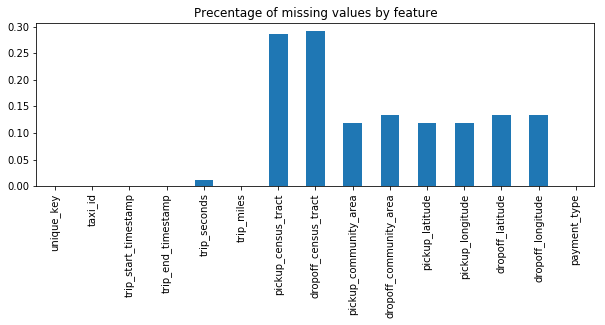

In [6]:
# Plotting missing values rate
(df.isnull().sum()/(30000)).plot(kind='bar', figsize=(10,3))
plt.title('Precentage of missing values by feature')
plt.show()

Our first obsercation that many pickup and dropoff locations are missing, <br> 
since our goal is to predict trip duraion we have to know the origin and destination of the trip. <br>
For this reason, when building the dataset we will filter missing destination and origin rows

In [7]:
df = df.dropna()

In [8]:
df[['trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds']].head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds
2,2014-06-27 11:30:00+00:00,2014-06-27 11:30:00+00:00,60.0
3,2014-10-18 15:30:00+00:00,2014-10-18 15:45:00+00:00,1020.0
8,2013-03-16 15:45:00+00:00,2013-03-16 16:00:00+00:00,1320.0
9,2015-02-22 12:30:00+00:00,2015-02-22 12:45:00+00:00,840.0
11,2014-03-05 14:45:00+00:00,2014-03-05 15:00:00+00:00,360.0


We note that the trip start and end time are rounded to 15 minutes <br>
However trip_seconds is not round, so it probably reflects a more accurate measurement of the ride time

## Analyzing features distributions

In [9]:
df['trip_start_timestamp'] = df['trip_start_timestamp'].apply(pd.Timestamp)
df['trip_end_timestamp'] = df['trip_end_timestamp'].apply(pd.Timestamp)

Trip trends over the years:

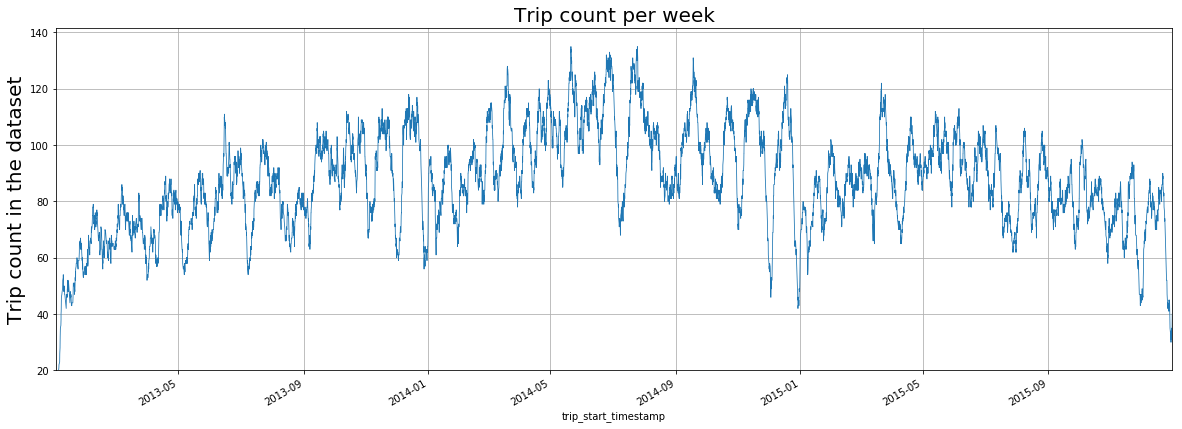

In [10]:
total_trips = df.set_index('trip_start_timestamp').sort_index()['trip_miles'].fillna(0).rolling('7d').count()
total_trips.plot(lw=0.8, figsize=(20,7))
plt.ylim(20,)
plt.title('Trip count per week', size=20)
plt.ylabel('Trip count in the dataset', size=20)
plt.grid()
plt.show()

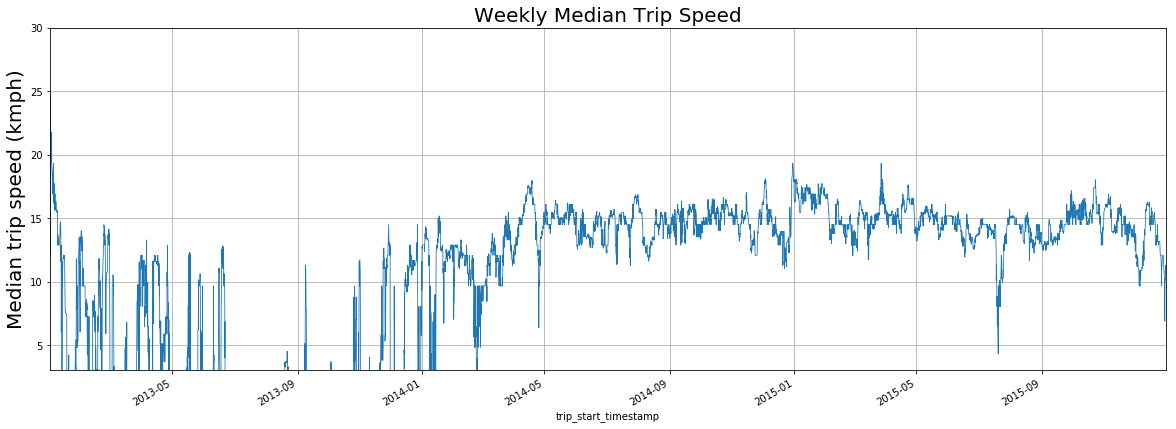

In [11]:
df['trip_speed_kmph'] = (df['trip_miles'] * (1.60934)) / ((df['trip_seconds'] + .01)/ (60 * 60))

trip_speed = df.set_index('trip_start_timestamp').sort_index()['trip_speed_kmph'].fillna(0).rolling('7d').median()
trip_speed.plot(lw=0.8, figsize=(20,7))
plt.ylim(3,30)
plt.title('Weekly Median Trip Speed', size=20)
plt.ylabel('Median trip speed (kmph)', size=20)
plt.grid()
plt.show()

There doesn't seem to be a clear trend to the total number of rides or to the travel speed

## Filtering out unreasonable trip speeds

In [12]:
# Impute data
df = df[df['trip_miles'] > 0.2] # Filter very short trips
df = df[df['trip_seconds'] > 2] # Filter very short trips
df = df[df['trip_speed_kmph'].between(5,120)] # Filter very FAST and very SLOW trips

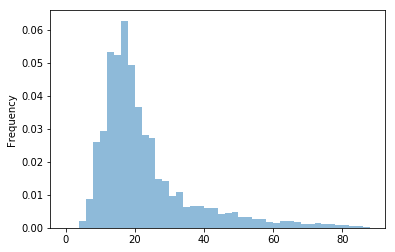

In [13]:
df['trip_speed_kmph'].dropna().plot(kind='hist', bins=range(0,90, 2), alpha=0.5, density=True)
plt.show()

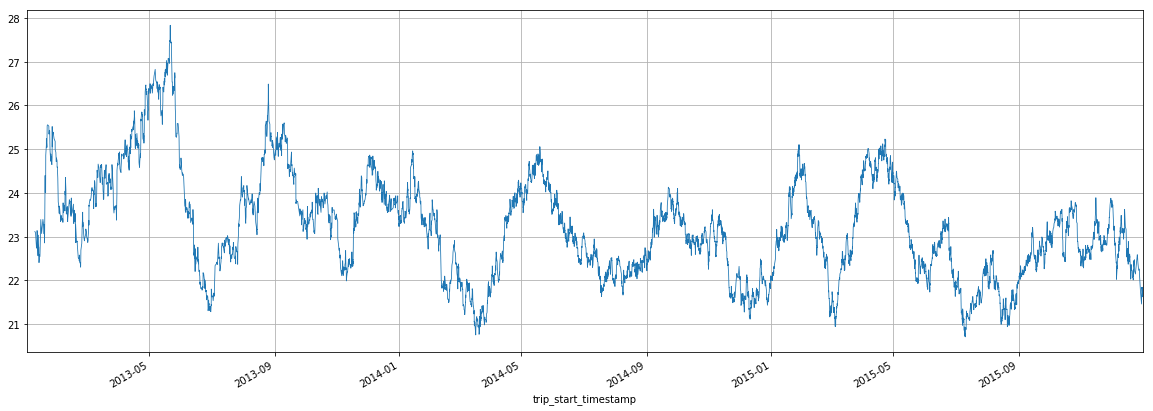

In [14]:
total_trips = df.set_index('trip_start_timestamp').sort_index()['trip_speed_kmph'].fillna(0).rolling('30d', min_periods=30).mean()
total_trips.plot(lw=0.8, figsize=(20,7))
plt.grid()
plt.show()

## Exemine the effect of the trip date and time on the trip duration

In [15]:
df['hour_of_day'] = df['trip_start_timestamp'].dt.hour
df['day_of_week'] = df['trip_start_timestamp'].dt.weekday

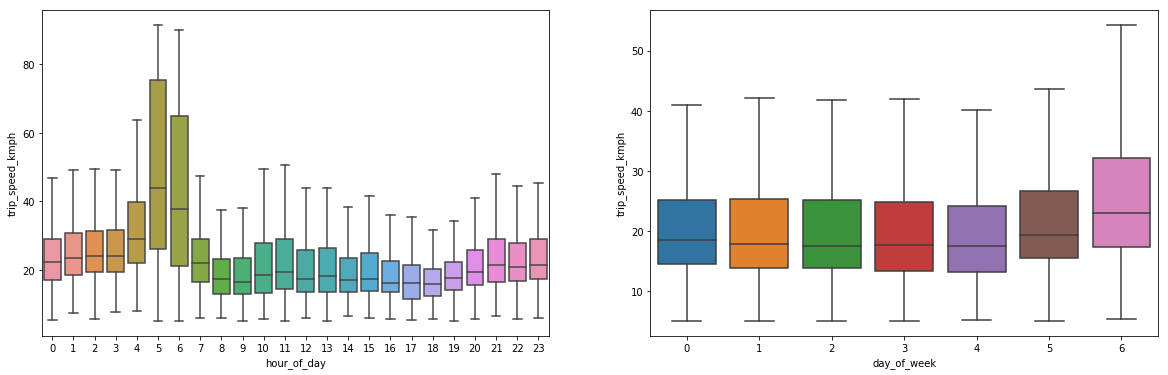

In [16]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
sns.boxplot(x='hour_of_day', y='trip_speed_kmph', data=df, showfliers=False)
plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_week', y='trip_speed_kmph', data=df, showfliers=False)
plt.show()

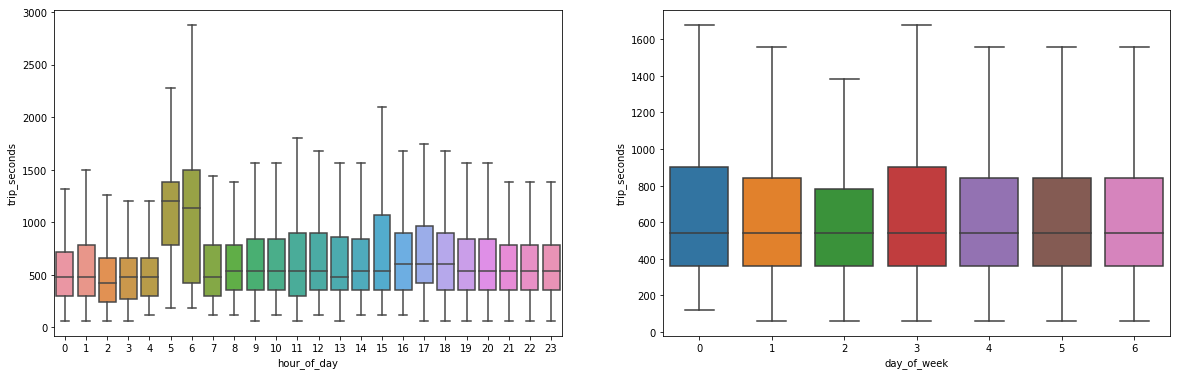

In [17]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
sns.boxplot(x='hour_of_day', y='trip_seconds', data=df, showfliers=False)
plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_week', y='trip_seconds', data=df, showfliers=False)
plt.show()

In [19]:
df.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,payment_type,trip_speed_kmph,hour_of_day,day_of_week
3,a63b9584767b078d5bf4c1f48fd8d6ac8bc75ca0,efd204f38a83a59df5bf4a1fe004aa291183e235ee40ee...,2014-10-18 15:30:00+00:00,2014-10-18 15:45:00+00:00,1020.0,2.3,1.703133e+10,1.703108e+10,33.0,8.0,41.859350,-87.617358,41.892508,-87.626215,Credit Card,13.063926,15,5
8,a5fa3bde982a3f3c27d894bba0b32567a756059c,fce5ce375d93bcded7c5006c25c5b82414269dd8e1607e...,2013-03-16 15:45:00+00:00,2013-03-16 16:00:00+00:00,1320.0,2.1,1.703107e+10,1.703183e+10,7.0,22.0,41.922083,-87.634156,41.919225,-87.671446,Credit Card,9.217059,15,5
9,a72872a5bc10a8edc246e85617fda51a52272caa,053eb496428e68964024977131254484f3dbc6d5aad8e1...,2015-02-22 12:30:00+00:00,2015-02-22 12:45:00+00:00,840.0,3.9,1.703107e+10,1.703184e+10,7.0,32.0,41.922083,-87.634156,41.880994,-87.632746,Cash,26.898648,12,6
11,a6668ff104cca12e24e833eadc5b2895f74c13f7,5445efb47d0f94d15a8b2171fb9ba042e80b51ba6fb25f...,2014-03-05 14:45:00+00:00,2014-03-05 15:00:00+00:00,360.0,0.9,1.703128e+10,1.703132e+10,28.0,32.0,41.879255,-87.642649,41.884987,-87.620993,Cash,14.483658,14,2
12,a5d526255e044c0b300d707ca0d3879e2a510ec2,b4d59da1d7b8c002094752251906d9a3bcc6c7ea71a15f...,2015-02-13 16:00:00+00:00,2015-02-13 16:15:00+00:00,600.0,1.3,1.703128e+10,1.703132e+10,28.0,32.0,41.879255,-87.642649,41.877406,-87.621972,Cash,12.552643,16,4


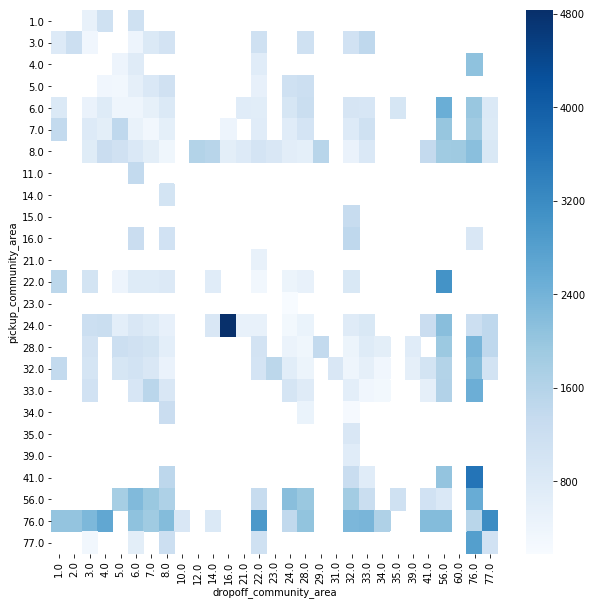

In [31]:
plt.figure(figsize=(10,10))
sns.heatmap(df.pivot_table(index='pickup_community_area', columns='dropoff_community_area', values='trip_seconds'), cmap='Blues')
plt.show()